In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean as cmo
import seaborn as sb
import cftime

def mask_composite(ds, var, start_year=0, min_lat=-90, max_lat=90, min_lon=-180, max_lon=360):
    X = np.meshgrid(ds.x.data,ds.y.data)
    mask = xr.DataArray(np.sqrt(X[0]**2 + X[1]**2) <= 10, dims=['x', 'y'])
    
    idx_region = (ds.snap_time.dt.year > start_year) & (ds.snap_lat >= min_lat) & (ds.snap_lat <= max_lat) & \
    (ds.snap_lon >= min_lon) & (ds.snap_lon <= max_lon)
    
    test = ds[var][idx_region,:,:]
    test = xr.where(abs(test)>1e10, np.nan, test)
    test = xr.where(test==0, np.nan, test)

    out_masked = xr.where(mask, test, np.nan)
    return out_masked

def create_date_index(ds, middle_date):
    date_low = (middle_date - 15)%365 + 1
    date_high = (middle_date + 15)%365 + 1
    
    if date_high > date_low: 
            idx = ((ds.time.dt.dayofyear >= date_low) & (ds.time.dt.dayofyear <= date_high))
    if date_high < date_low:
            idx = ((ds.time.dt.dayofyear >= date_low) | (ds.time.dt.dayofyear <= date_high))
            
    return idx

def composites_doy(ds, var): 
    test = ds[f'snap_{var}_anom']
    test = xr.where(abs(test)>1e10, np.nan, test)
    test = xr.where(test==0, np.nan, test)

    X = np.meshgrid(ds.x.data,ds.y.data)
    mask = xr.DataArray(np.sqrt(X[0]**2 + X[1]**2) <= 10, dims=['x', 'y'])
    masked_var = xr.where(mask, test, np.nan)

    # subsample for periods that we have ocean output (daily, timestamp is 12:00:00)
    ds.snap_time.dt.hour == 12
    time = ds.snap_time[ds.snap_time.dt.hour == 12]
    snap = ds.snapshot[ds.snap_time.dt.hour == 12]

    flux = masked_var[:,:,ds.snap_time.dt.hour == 12]

    # create a dataset to group snapshots by day of year
    ds_masked = xr.Dataset(
        data_vars=dict(
            flux=(["x", "y", "snapshot"], flux.data),
            time=(["snapshot"], time.data),
        ),
        coords=dict(
            x=ds.x.data,
            y=ds.y.data,
            snapshot=snap.data,
        ),
        attrs=dict(description=f"{var} snapshots"),
    )

    flux_avg_tot = flux.mean(dim="snapshot")
    flux_avg_doy = ds_masked.flux.groupby(time.dt.dayofyear).mean(skipna=True)
    
    return ds_masked

In [131]:
nyears = {"CM4":95, "ESM4":100}
l_color = {"CM4":'k', "ESM4":'b'}

vname = 'dic_stf_gas'

dx = 0.5 * 111e3

ds = xr.open_dataset(f"/work/Katherine.Turner/tempest-extremes/odiv-251/comp_{vname}/comp_{vname}_anom.nc", use_cftime=True)
ds_out = composites_doy(ds, vname)

In [132]:
x1 = ds_out.flux.groupby(ds_out.time).mean()
c1 = ds_out.flux.groupby(ds_out.time).count()

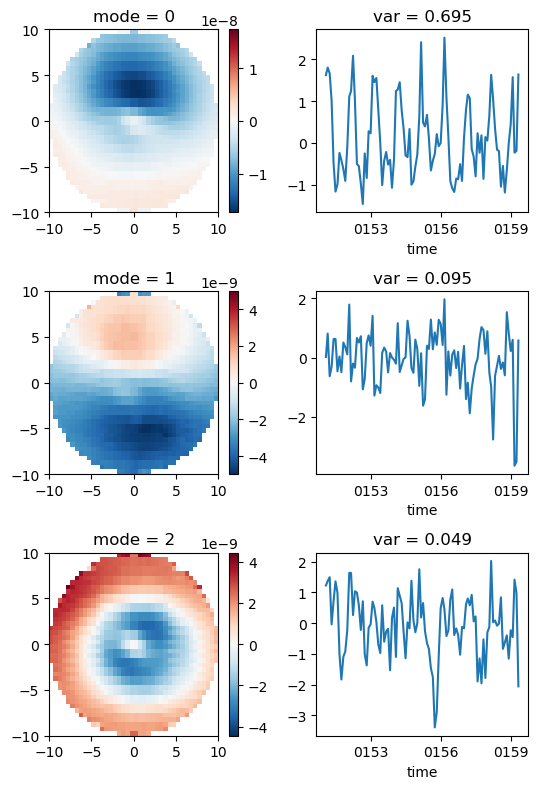

In [135]:
x_month = x1.resample(time='M').mean(dim='time')

xx = x_month - x_month.mean(dim='time')

solver = Eof(xx.transpose())

eof = solver.eofsAsCovariance(neofs=4)
pc = solver.pcs(npcs=4, pcscaling=1)
v = solver.varianceFraction()

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(5.5,8))
axs = axs.flatten()

eof[0,:,:].plot(ax=axs[0],cbar_kwargs={'label': ''})
pc[:100,0].plot(ax=axs[1])

eof[1,:,:].plot(ax=axs[2],# vmin=-8, vmax=8, extend='neither',
                cmap="RdBu_r",cbar_kwargs={'label': ''})
pc[:100,1].plot(ax=axs[3])

eof[2,:,:].plot(ax=axs[4],cbar_kwargs={'label': ''})
pc[:100,2].plot(ax=axs[5])


for i in range(6):
    axs[i].set_ylabel('')
    if i%2 == 0:
        axs[i].set_xlabel('')
    if i%2 == 1:
        axs[i].set_title(f'var = {v[int((i-1)/2)].data:.3f}')

plt.tight_layout()

plt.savefig(f'/home/Katherine.Turner/Figures/CM4_storm_{vname}_eof_month.png', format='png', dpi=100)

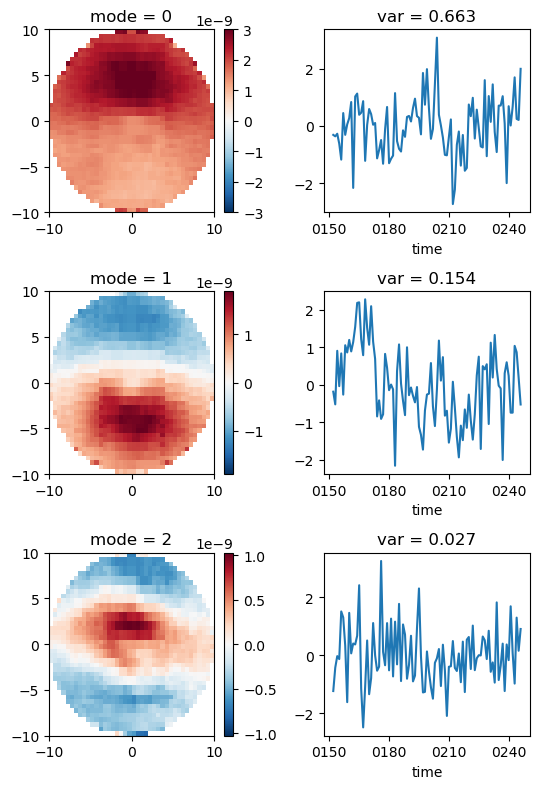

In [137]:
x_month = x1.resample(time='Y').mean(dim='time')

xx = x_month - x_month.mean(dim='time')

solver = Eof(xx.transpose())

eof = solver.eofsAsCovariance(neofs=4)
pc = solver.pcs(npcs=4, pcscaling=1)
v = solver.varianceFraction()

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(5.5,8))
axs = axs.flatten()

eof[0,:,:].plot(ax=axs[0],cbar_kwargs={'label': ''}, vmin=-3e-9, vmax=3e-9, extend="neither",
               cmap="RdBu_r")
pc[:100,0].plot(ax=axs[1])

eof[1,:,:].plot(ax=axs[2],cbar_kwargs={'label': ''})
pc[:100,1].plot(ax=axs[3])

eof[2,:,:].plot(ax=axs[4],cbar_kwargs={'label': ''})
pc[:100,2].plot(ax=axs[5])

#eof[3,:,:].plot(ax=axs[6])
#pc[:100,3].plot(ax=axs[7])


for i in range(6):
    axs[i].set_ylabel('')
    if i%2 == 0:
        axs[i].set_xlabel('')
    if i%2 == 1:
        axs[i].set_title(f'var = {v[int((i-1)/2)].data:.3f}')

plt.tight_layout()

plt.savefig(f'/home/Katherine.Turner/Figures/CM4_storm_{vname}_eof_year.png', format='png', dpi=100)

In [90]:
import scipy.signal

In [102]:
f, Pxx_spec = scipy.signal.periodogram(x_month.mean(dim=['x','y']), fs=12)

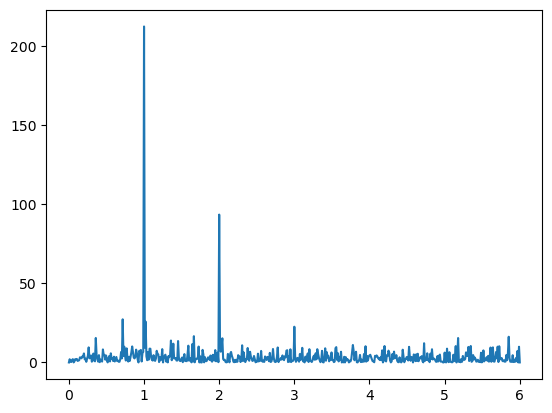

In [106]:
plt.plot(f, Pxx_spec)